In [1]:
# SciPy imports
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import seaborn as sns
import pickle
import datetime
import random

# Other necessary imports
import sqlite3
import ast
from collections import defaultdict
import pprint

In [2]:
conn = sqlite3.connect('database.sqlite')
cursor = conn.cursor()
print("Opened database successfully")

Opened database successfully


# EDA

Let's get a brief overview of the data for the major tables:

### table: SearchInfo

In [6]:
# preview of SearchInfo table and schema, ordered by SearchDate ascending
q = '''
SELECT * FROM SearchInfo
ORDER BY SearchDate
LIMIT 5;
'''
%time pd.read_sql_query(q, conn)

,SearchID,SearchDate,IPID,UserID,IsUserLoggedOn,SearchQuery,LocationID,CategoryID,SearchParams
0,5604821,2015-04-25 00:00:00.0,2103665,469526,0,,1261,34,
1,13177673,2015-04-25 00:00:00.0,544882,2803738,0,,3137,41,{143:'Samsung'}
2,18569679,2015-04-25 00:00:00.0,1150353,1215256,0,,3960,22,"{83:'Платья и юбки', 175:'Женская одежда', 90:..."
3,30404777,2015-04-25 00:00:00.0,1069851,647606,1,,1676,34,
4,41191882,2015-04-25 00:00:00.0,292976,2177961,0,,3771,60,"{115:'74-80 см (7-12 мес)', 179:'Платья и юбки..."


> When did the last search occur?

In [7]:
q = '''
SELECT MAX(SearchDate) FROM SearchInfo;
'''
%time pd.read_sql_query(q, conn)

,MAX(SearchDate)
0,2015-05-20 18:00:00.0


 > How many Searches occurred in our time window?

In [16]:
q = '''
SELECT COUNT(DISTINCT(SearchID)) AS "Total Searches"
FROM SearchInfo;
'''
%time pd.read_sql_query(q, conn)

,Total Searches
0,112159462


In [18]:
# sanity check to ensure that SearchID is continuous and unique
q = '''
SELECT MIN(SearchID), MAX(SearchID), COUNT(*) AS "Total Rows"
FROM SearchInfo;
'''
%time pd.read_sql_query(q, conn)

,MIN(SearchID),MAX(SearchID),Total Rows
0,1,113964820,112159462


Okay - that's good to know.  The range of SearchIDs for the SearchInfo table is **not** continuous.  The MAX SearchID is greater than the number of rows, so there must be some SearchIDs between \#1 - \#113,964,820 missing.

### table: UserInfo

In [9]:
# preview of trainSearchStream table and schema
q = '''
SELECT * FROM UserInfo
LIMIT 5;
'''
%time pd.read_sql_query(q, conn)

,UserID,UserAgentID,UserAgentOSID,UserDeviceID,UserAgentFamilyID
0,1,44073,30,2019,9
1,2,12505,20,2014,85
2,3,24256,20,2014,64
3,4,57133,20,2014,25
4,5,57133,20,2014,25


> How many distinct Users are there in our dataset?

In [13]:
q = '''
SELECT COUNT(DISTINCT(UserID)) AS "Total Users" FROM UserInfo;
'''
%time pd.read_sql_query(q, conn)

,Total Users
0,4284823


> What does the distribution of Searches Per User look like?

In [12]:
q = '''
SELECT UserID, COUNT(DISTINCT(SearchID)) AS "Num_Searches"
FROM SearchInfo
GROUP BY UserID;
'''

%time user_search_distribution = pd.read_sql_query(q, conn)

CPU times: user 2min 21s, sys: 1min 51s, total: 4min 12s
Wall time: 10min 45s


In [15]:
user_search_distribution['Num_Searches'].describe()

count    4.295465e+06
mean     2.611113e+01
std      9.623540e+01
min      1.000000e+00
25%      1.000000e+00
50%      5.000000e+00
75%      1.700000e+01
max      2.322800e+04
Name: Num_Searches, dtype: float64

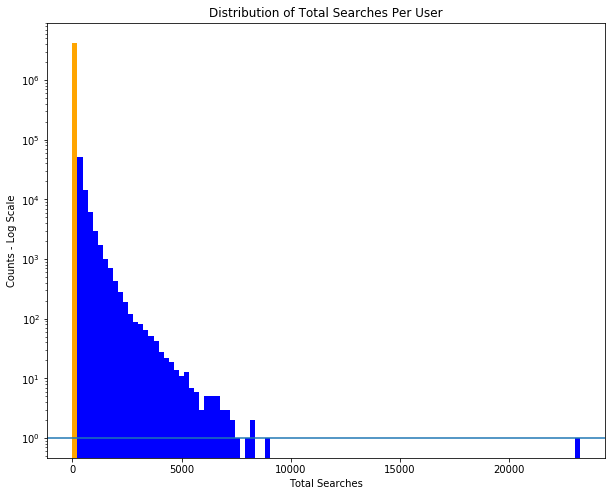

In [31]:
# annotate line as 'y=1'
plt.figure(figsize=(10,8))
n, bins, patches = plt.hist(user_search_distribution['Num_Searches'], bins=100, log=True, color='b')
patches[0].set_fc('orange')
plt.axhline(1)
plt.title('Distribution of Total Searches Per User')
plt.xlabel('Total Searches')
plt.ylabel('Counts - Log Scale')
plt.show()

That one outlier seems pretty suspicious - could be a bot.

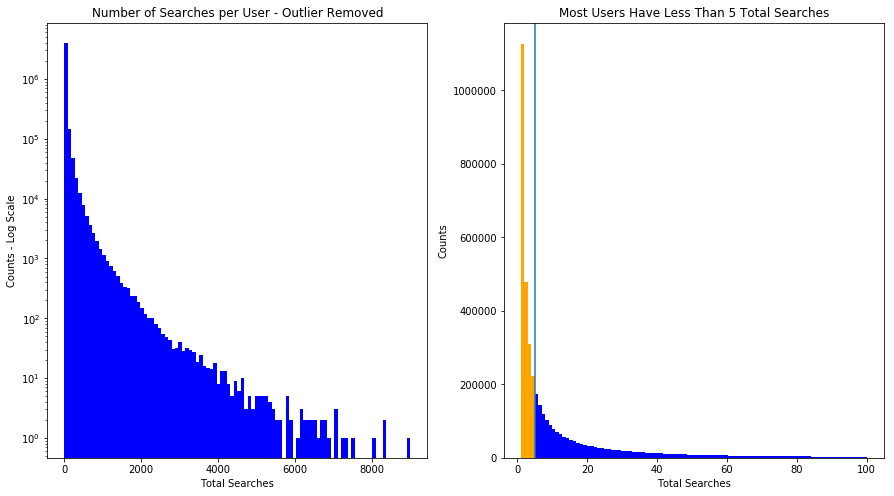

In [72]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,8))
n, bins, patches = ax1.hist(user_search_distribution['Num_Searches'], bins=100, range=(1,9000), log=True, color='b')
ax1.title.set_text('Number of Searches per User - Outlier Removed')
ax1.set(xlabel='Total Searches', ylabel='Counts - Log Scale')

n, bins, patches = ax2.hist(user_search_distribution['Num_Searches'], bins=100, range=(1,100), log=False, color='b')
for i in patches[0:4]:
    i.set_fc('orange')
ax2.axvline(user_search_distribution['Num_Searches'].median())
ax2.title.set_text('Most Users Have Less Than 5 Total Searches')
ax2.set(xlabel='Total Searches', ylabel='Counts')
plt.show()
# annotate line to say 'x=5'

### table: trainSearchStream

In [20]:
# preview of trainSearchStream table and schema
q = '''
SELECT * FROM trainSearchStream
LIMIT 10;
'''
pd.read_sql_query(q, conn)

,SearchID,AdID,Position,ObjectType,HistCTR,IsClick
0,2,11441863,1,3,0.001804,0
1,2,22968355,7,3,0.004723,0
2,3,212187,7,3,0.029701,0
3,3,34084553,1,3,0.0043,0
4,3,36256251,2,2,,
5,4,2073399,6,1,,
6,4,6046052,7,1,,
7,4,17544913,8,1,,
8,4,20653823,1,3,0.003049,0
9,4,24129570,2,2,,


We notice here that some of the column values for IsClick are NULL.  The data notes from Kaggle inform you that only Context Ads have class labels for IsClick.  Context Ads are denoted as ObjectType 3.

In [21]:
# sanity check to verify that ObjectType 1 & 2 lack IsClick classification
q = '''
SELECT ObjectType, SUM(IsClick) FROM TrainSearchStream
WHERE ObjectType=1 OR ObjectType=2
GROUP BY ObjectType;
'''

%time pd.read_sql_query(q, conn)

,SUM(IsClick)
0,0.0
1,0.0


> How many total impressions were there in the Training Set?

In [73]:
q = '''
SELECT COUNT(*) AS "Total Impressions" FROM TrainSearchStream;
'''
%time pd.read_sql_query(q, conn)

,COUNT(*)
0,392356948


> What is the Class Balance like for 'IsClick' in this dataset?  

> How many clicks were there total?  

> How many Context Ad impresssions were served?

In [76]:
q = '''
SELECT (CAST(SUM(IsClick) AS FLOAT) / COUNT(IsClick)) AS "Total Click Through Rate",
       SUM(IsClick) AS "Total Clicks", 
       COUNT(IsClick) AS "Total Context Ad Impressions"
FROM TrainSearchStream
WHERE ObjectType=3;
'''
%time pd.read_sql_query(q, conn)

,Total Click Through Rate,Total Clicks,Total Context Ad Impressions
0,0.006028,1146289,190157735


You might have known this intuitively, but now let's put it out in the open:

### In Click-Prediction problems, your classes are gonna be WAY imbalanced.  

*Virtually no one clicks on ads, in our case -* **a little over half of a percent of impressions ever got clicked.**

> On what date did the last Search occur for TrainSearchStream?

In [6]:
q = '''
SELECT s.SearchID, s.SearchDate 
FROM (  SELECT SearchID, SearchDate
        FROM SearchInfo
        ORDER BY SearchDate DESC) AS s
JOIN TrainSearchStream AS tss
ON tss.SearchID = s.SearchID
LIMIT 15;
'''

%time pd.read_sql_query(q, conn)

CPU times: user 2min 6s, sys: 4min 13s, total: 6min 19s
Wall time: 20min 23s


,SearchID,SearchDate
0,108053000,2015-05-20 17:59:55.0
1,108053000,2015-05-20 17:59:55.0
2,108053000,2015-05-20 17:59:55.0
3,81843230,2015-05-20 17:59:51.0
4,81843230,2015-05-20 17:59:51.0
5,81843230,2015-05-20 17:59:51.0
6,92209219,2015-05-20 17:59:51.0
7,92209219,2015-05-20 17:59:51.0
8,92209219,2015-05-20 17:59:51.0
9,33148528,2015-05-20 17:59:49.0


In [8]:
q = '''
SELECT s.SearchID, s.SearchDate 
FROM (  SELECT SearchID, SearchDate
        FROM SearchInfo
        ORDER BY SearchDate ASC) AS s
JOIN TestSearchStream AS tss
ON tss.SearchID = s.SearchID
LIMIT 15;
'''
%time pd.read_sql_query(q, conn)

CPU times: user 27 s, sys: 1min 19s, total: 1min 46s
Wall time: 7min 13s


,SearchID,SearchDate
0,15084095,2015-05-12 00:00:00.0
1,15084095,2015-05-12 00:00:00.0
2,27330066,2015-05-12 00:00:00.0
3,27330066,2015-05-12 00:00:00.0
4,27330066,2015-05-12 00:00:00.0
5,38632965,2015-05-12 00:00:00.0
6,38632965,2015-05-12 00:00:00.0
7,38632965,2015-05-12 00:00:00.0
8,50492707,2015-05-12 00:00:00.0
9,50492707,2015-05-12 00:00:00.0


> We can see here that the cutoff for Train/Test is **not** date-specific.  It will be easier to exclude the SearchInfo searches that yielded Test Set impressions by creating a new subset table of SearchInfo, with the SearchIDs of TestStreamSearch removed.

### tables: AdsInfo & Category

In [78]:
# preview of AdsInfo table and schema
q = '''
SELECT * FROM AdsInfo
LIMIT 5;
'''
pd.read_sql_query(q, conn)

,AdID,LocationID,CategoryID,Params,Price,Title,IsContext
0,1,343,43,"{1283:'С пробегом', 633:'Синий', 1159:0, 210:'...",160000,"Toyota Estima, 1993",0
1,2,992,34,"{817:'Кузов', 5:'Запчасти', 598:'Для автомобил...",750,Передние брызговики Форд Фокус 2 родные,0
2,3,3771,53,{181:'Промышленное'},18000,Дровокол,0
3,4,4294,57,{130:'Приборы и аксессуары'},1500,Продам ходули складные,0
4,5,1344,34,"{817:'Автосвет', 5:'Запчасти', 598:'Для автомо...",800,Поворотник R - Carina (20317),0


In [11]:
q = '''
SELECT COUNT(DISTINCT(AdID)) AS "Total Ads", 
       MAX(AdID), 
       SUM(IsContext) AS "Total Context Ads",
       CAST(SUM(IsContext) AS FLOAT)/COUNT(DISTINCT(AdID)) AS "Context Ad %age"
FROM AdsInfo;
'''
%time pd.read_sql_query(q, conn)

CPU times: user 28.8 s, sys: 8.17 s, total: 37 s
Wall time: 45.1 s


,Total Ads,MAX(AdID),Total Context Ads,Context Ad %age
0,36893298,36893298,28570,0.000774


> Which Ads got the most Phone Requests and Page Visits?  (Note these details are only available for the Non-Context Ads)

In [14]:
q = '''
WITH v AS (
    SELECT AdID, COUNT(*) AS "Page_Visits"
    FROM VisitsStream
    GROUP BY AdID
),
    pr AS (
    SELECT AdID, COUNT(*) AS "Phone_Requests"
    FROM PhoneRequestsStream
    GROUP BY AdID
)

SELECT top10VisitedAds.AdID, Page_Visits, 
       Phone_Requests, Total_Looksies, 
       Title, Price, CategoryID
FROM
    (SELECT AdID, Page_Visits, Phone_Requests, Page_Visits+Phone_Requests AS Total_Looksies
    FROM v
    LEFT JOIN pr USING(AdID)
    UNION ALL
    SELECT AdID, Page_Visits, Phone_Requests, Page_Visits+Phone_Requests AS Total_Looksies
    FROM pr
    LEFT JOIN v USING(AdID)
    WHERE v.AdID IS NULL
    ORDER BY Total_Looksies DESC
    LIMIT 10) top10VisitedAds
JOIN AdsInfo a
ON top10VisitedAds.AdID = a.AdID
'''
%time pd.read_sql_query(q, conn)

CPU times: user 1min 55s, sys: 13.3 s, total: 2min 8s
Wall time: 2min 18s


,AdID,Page_Visits,Phone_Requests,Total_Looksies,Title,Price,CategoryID
0,35635728,81814,3,81817,"ВАЗ 2110, 2011",300000,43
1,28675022,31427,1,31428,Услуги сантехника на дом в астрахани,0,250005
2,25183213,9389,7469,16858,"Audi 80, 1990",95000,43
3,9914685,9109,7279,16388,"Citroen C3, 2010",390000,43
4,34510166,8793,7299,16092,FAW V2 1.3 МТ,347500,43
5,18998643,14762,9,14771,Услуги грузчиков и транспорта в Ярославле,100,250005
6,12409259,7995,6485,14480,"Opel Omega, 1989",0,43
7,14965571,7611,6168,13779,"Dodge Caliber, 2011",682500,43
8,1819699,6800,5373,12173,Отдам в хорошие руки,70000,43
9,15004312,3599,2860,6459,"Nissan March, 2007",250000,43


> Which Ads got the most Clicks?

In [ ]:
q='''
WITH top_clicks AS (
    SELECT AdID, COUNT(IsClick) AS Clicks
    FROM trainSearchStream tss
    WHERE IsClick=1
    GROUP BY AdID
    ORDER BY Clicks DESC
    LIMIT 10
)

SELECT t.AdID, Title, Clicks, CategoryID, Price
FROM top_clicks t
JOIN AdsInfo a
ON t.AdID = a.AdID;
'''
%time pd.read_sql_query(q, conn)

# Summary

- Timeframe between 4/25/15 - 5/20/15

**Search Related:**
- 112,159,462 Searches

**Impression Related:**
- 392,356,948 Impressions Served

- 190,157,735 Impresssions were Context Ads

- 0.6028% of Context Ads were clicked

- 36,893,298 Distinct Ads (Only .0774% are Context Ads)

**User Related:**
- 4,284,823 Users

- Median Number of Searches Per User is 5

- Interquartile range for Searches Per User is 1 - 17 Searches


## Addendum: Setting Indexes

**Note:** these are compiled in batch_create_tables.py
    
It will save you some time to just run them all together overnight.  *See README.md for instructions.*

In [3]:
q = '''
CREATE INDEX AdID_Index ON VisitsStream(AdID);

CREATE INDEX AdID_Index2 ON PhoneRequestsStream(AdID);
'''
#cursor.executescript(q)

In [4]:
script = '''

-- SQLite doesn't have a way to add a primary key to an already created table.
-- If you look at the schema of these tables before having done any alterations, 
-- you'll notice that they have some errors.  This re-creation of the tables with 
-- primary keys relieves that issue.

ALTER TABLE trainSearchStream RENAME TO old_tss;

CREATE TABLE trainSearchStream
    (
    SearchID INTEGER,
    AdID INTEGER,
    Position INTEGER,
    ObjectType INTEGER,
    HistCTR REAL,
    IsClick INTEGER,
    PRIMARY KEY (SearchID, AdID)
    );

INSERT INTO trainSearchStream 
    SELECT * FROM old_tss;
 
DROP TABLE old_tss;

ALTER TABLE SearchInfo RENAME TO old_si;

CREATE TABLE SearchInfo
    (
    SearchID INTEGER PRIMARY KEY,
    SearchDate DATETIME,
    IPID INTEGER,
    UserID INTEGER,
    IsUserLoggedOn INTEGER,
    SearchQuery,
    LocationID INTEGER,
    CategoryID INTEGER,
    SearchParams
    );

INSERT INTO SearchInfo
    SELECT * FROM old_si;
 
DROP TABLE old_si;

-- Create another index on AdID for trainSearchStream

CREATE INDEX AdID_Index_tss ON trainSearchStream(AdID, SearchID);
'''
#cursor.executescript(script)

In [4]:
# creates table of Searches that omits SearchIDs with impressions in the testSearchStream
# we have less use for them since those impressions don't have IsClick labels
q = '''
CREATE TABLE SearchInfo2
    (
    SearchID INTEGER PRIMARY KEY,
    SearchDate DATETIME,
    IPID INTEGER,
    UserID INTEGER,
    IsUserLoggedOn INTEGER,
    SearchQuery,
    LocationID INTEGER,
    CategoryID INTEGER,
    SearchParams
    );

INSERT INTO SearchInfo2
    SELECT * FROM SearchInfo
    WHERE SearchID NOT IN (
        SELECT SearchID 
        FROM TestSearchStream);

CREATE INDEX User_index ON SearchInfo2(UserID);
'''
#%time cursor.executescript(q)

CPU times: user 5min 46s, sys: 4min 22s, total: 10min 9s
Wall time: 23min


#### Sanity Check

SearchInfo2 should yield fewer SearchIDs than stock SearchInfo

In [9]:
q = '''
SELECT COUNT(SearchID)
FROM SearchInfo;
'''
%time pd.read_sql_query(q, conn)

CPU times: user 23.6 s, sys: 1min 4s, total: 1min 28s
Wall time: 5min 30s


,COUNT(SearchID)
0,112159462


In [10]:
q = '''
SELECT COUNT(SearchID)
FROM SearchInfo2;
'''
%time pd.read_sql_query(q, conn)

CPU times: user 31 s, sys: 1min 30s, total: 2min 1s
Wall time: 7min 25s


,COUNT(SearchID)
0,107863985


FURTHER READING
- https://www.sqlitetutorial.net/sqlite-full-outer-join/
- https://modern-sql.com/feature/with
- https://medium.com/@JasonWyatt/squeezing-performance-from-sqlite-indexes-indexes-c4e175f3c346


### Kaggle:

In [3]:
# creates test_set that you would make predictions on with final model
# this script is also compiled in batch_create_tables.py
q = '''
CREATE TABLE test_merged AS

SELECT i.*, s.*, a.*
FROM testSearchStream i
JOIN SearchInfo s
    ON s.SearchID = i.SearchID
JOIN AdsInfo a
    ON a.AdID = i.AdID
WHERE ObjectType = 3;
'''
#%time cursor.executescript(q)

CPU times: user 1min 12s, sys: 2min 54s, total: 4min 7s
Wall time: 14min 2s
